Connected to .venv (Python 3.8.10)

# Testing Gerchberg-Saxton on the photonic lantern

In [115]:
%load_ext autoreload
%autoreload 2

from photonics.simulations.lantern_optics import LanternOptics
from photonics.simulations.optics import Optics
from hcipy import imshow_field, Wavefront
from photonics.utils import imshow_psf, zernike_names, nanify
from photonics.linearity import plot_linearity
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from tqdm import trange, tqdm

optics = Optics(lantern_fnumber=6.5)
lo = LanternOptics(optics)
lo.nmodes = 18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 9/9 [00:00<00:00, 224.85it/s]


### Injection-recovery test

In [116]:
def inject_recover(pupil, restore_outside=False):
    """
    This is a cut-back version of lo.GS_init that starts from pupil instead of optics.wf,
    and doesn't replace the amplitude with anything in the post-PL plane.
    """
    EM_out = lo.forward(optics, pupil)
    EM_in = lo.backward(optics, EM_out, restore_outside=restore_outside)
    return EM_in

def inject_recover_zernikes(z, a, verbose=False, restore_outside=False):
    pupil = optics.zernike_to_pupil(z, a)
    recovered = inject_recover(pupil, restore_outside=restore_outside)
    coeffs = optics.zernike_basis.coefficients_for(recovered.phase)[:lo.nmodes]
    if verbose:
        print(f"{zernike_names[z]} injected:", a)
        print(f"{zernike_names[z]} reconstructed:", coeffs[z])
        print(f"RMS cross-talk reconstructed:", np.sqrt(np.sum(coeffs ** 2) - coeffs[z] ** 2))
    return coeffs

In [117]:
for (z, a) in zip([0, 0, 4, 4], [0.1, 0.5, 0.1, 0.5]):
    inject_recover_zernikes(z, a, verbose=True);
    print()

tip injected: 0.1
tip reconstructed: 0.0904705743938286
RMS cross-talk reconstructed: 0.020569611536941496

tip injected: 0.5
tip reconstructed: 0.4621687307158614
RMS cross-talk reconstructed: 0.08569659127011567

astig45 injected: 0.1
astig45 reconstructed: 0.08867073644359125
RMS cross-talk reconstructed: 0.019025280881989536

astig45 injected: 0.5
astig45 reconstructed: 0.426758585837209
RMS cross-talk reconstructed: 0.08160154574513756



In [118]:
for (z, a) in zip([0, 0, 4, 4], [0.1, 0.5, 0.1, 0.5]):
    inject_recover_zernikes(z, a, verbose=True, restore_outside=True);
    print()

tip injected: 0.1
tip reconstructed: 0.07371115718681436
RMS cross-talk reconstructed: 0.03394120459809326

tip injected: 0.5
tip reconstructed: 0.37168879558226453
RMS cross-talk reconstructed: 0.15807965526117404

astig45 injected: 0.1
astig45 reconstructed: 0.06643257255053789
RMS cross-talk reconstructed: 0.029804929613500633

astig45 injected: 0.5
astig45 reconstructed: 0.32169876454431806
RMS cross-talk reconstructed: 0.1351170497013693



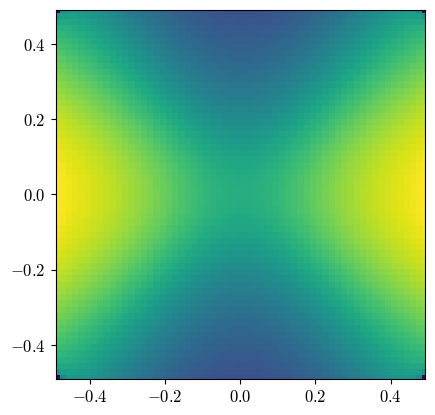

In [119]:
imshow_field(inject_recover(optics.zernike_to_pupil(4, 0.5)).phase)

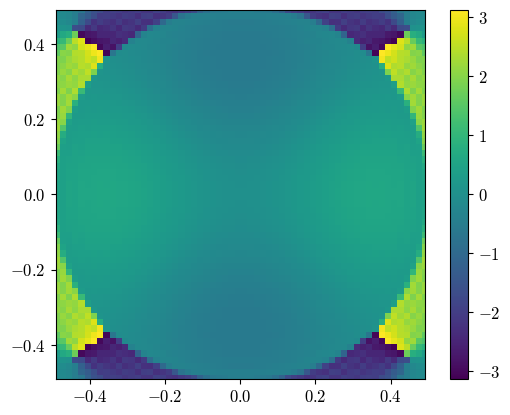

In [7]:
imshow_field(inject_recover(optics.zernike_to_pupil(4, 0.5), restore_outside=True).phase)
plt.colorbar()
# I think this is phase-wrapping because the reconstruction isn't incredibly different

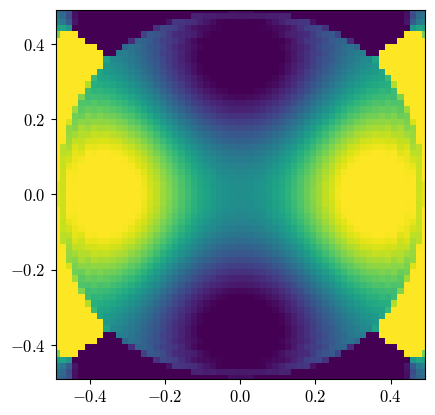

In [8]:
imshow_field(inject_recover(optics.zernike_to_pupil(4, 0.5), restore_outside=True).phase, vmin=-0.5, vmax=0.5)
# Shows the issue above was phase wrapping
# and that at the scale we injected we still have a reconstructed signal

Let's make linearity curves using just `inject_recover`. I'll do this with and without restoring the outside E field.

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


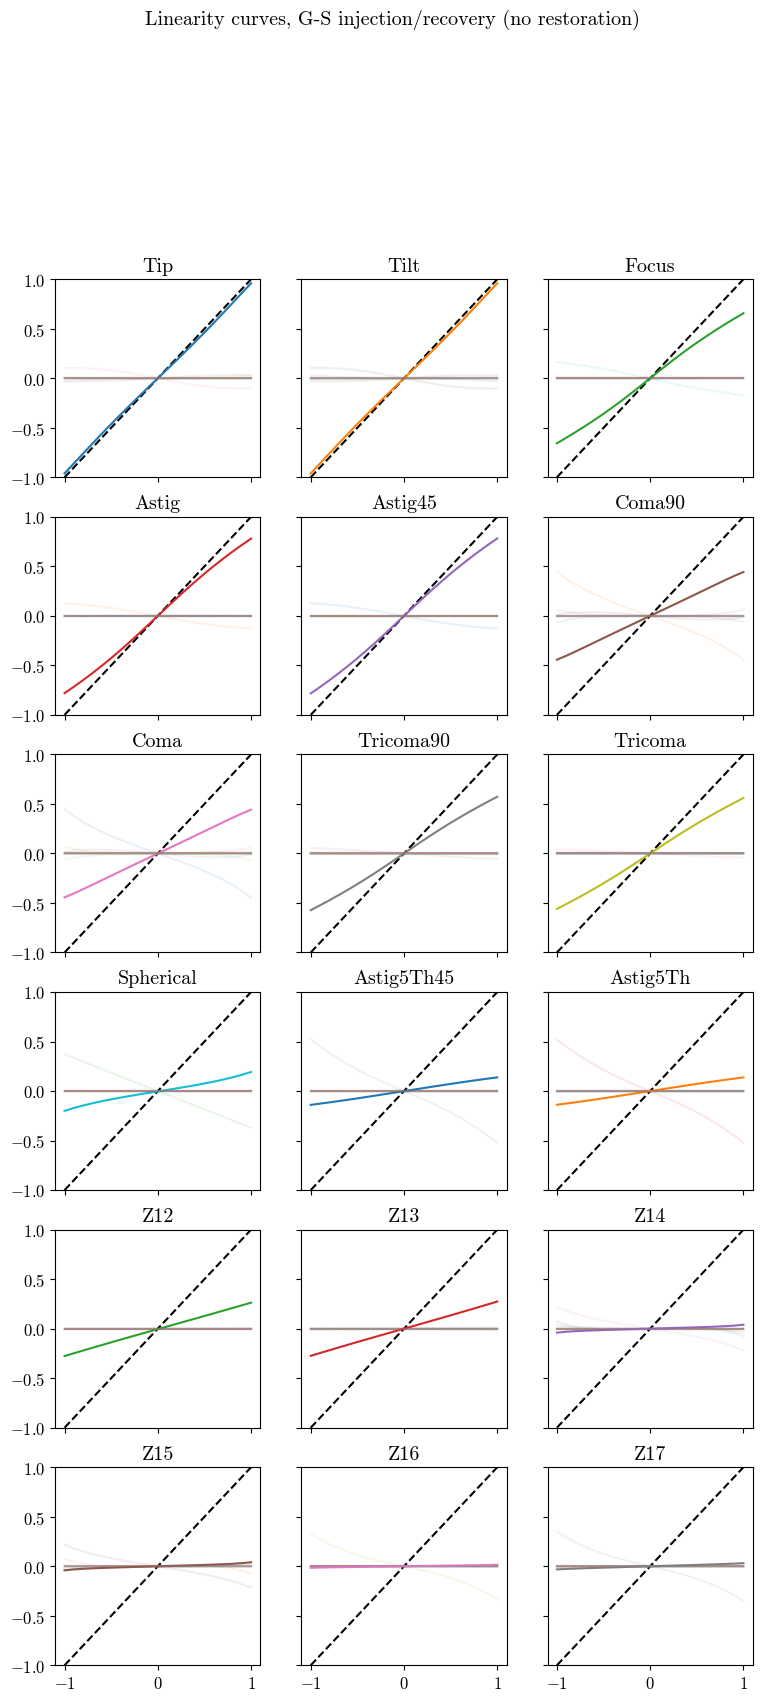

In [9]:
zr = np.arange(18)
ar = np.arange(-1.0, 1.01, 0.1)
sweep = np.zeros((len(zr), len(ar), len(zr)))
for (i, z) in enumerate(tqdm(zr)):
    for (j, a) in enumerate(ar):
        sweep[i,j,:] = inject_recover_zernikes(z, a)
        
plot_linearity(ar, sweep, "G-S injection/recovery (no restoration)")

In [10]:
inject_recover_zernikes([2, 4], [0.1, 0.1])

OldStyleField([-1.87538804e-13, -4.32369166e-10,  7.57310784e-02,
               -2.06014385e-10,  8.85466410e-02,  3.98991787e-10,
               -1.73416884e-09, -1.17675605e-09, -1.84258406e-09,
               -2.43196474e-02, -1.80499201e-02,  3.55134523e-10,
               -3.65029004e-03,  2.15058145e-10, -1.87747954e-09,
               -4.98310239e-10, -7.54472243e-10,  2.22269784e-10])

In [11]:
inject_recover_zernikes(2, 0.1)

OldStyleField([ 3.86298532e-09, -5.63089539e-09,  7.60046167e-02,
                1.06086354e-10, -2.26221083e-04, -8.53208517e-10,
                1.85350122e-09,  1.44354288e-09,  1.00391757e-09,
               -2.45499573e-02, -3.73303485e-04, -7.14852758e-10,
               -3.93457837e-03,  1.57696694e-10,  1.03872324e-10,
                2.16794508e-09,  4.42209395e-10, -1.63464357e-09])

In [12]:
inject_recover_zernikes(3, 0.7)

OldStyleField([ 2.74081262e-09,  8.55216012e-10,  1.89079952e-05,
                5.77466589e-01, -1.84447118e-03,  5.95809007e-10,
                3.80994261e-10, -1.26921168e-09,  7.04318611e-10,
               -3.34961330e-03, -3.37444337e-04, -1.03411655e-01,
               -2.58271194e-03,  5.36732596e-04, -2.19503554e-10,
                5.48167657e-11, -1.05689637e-09,  1.28657293e-10])

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


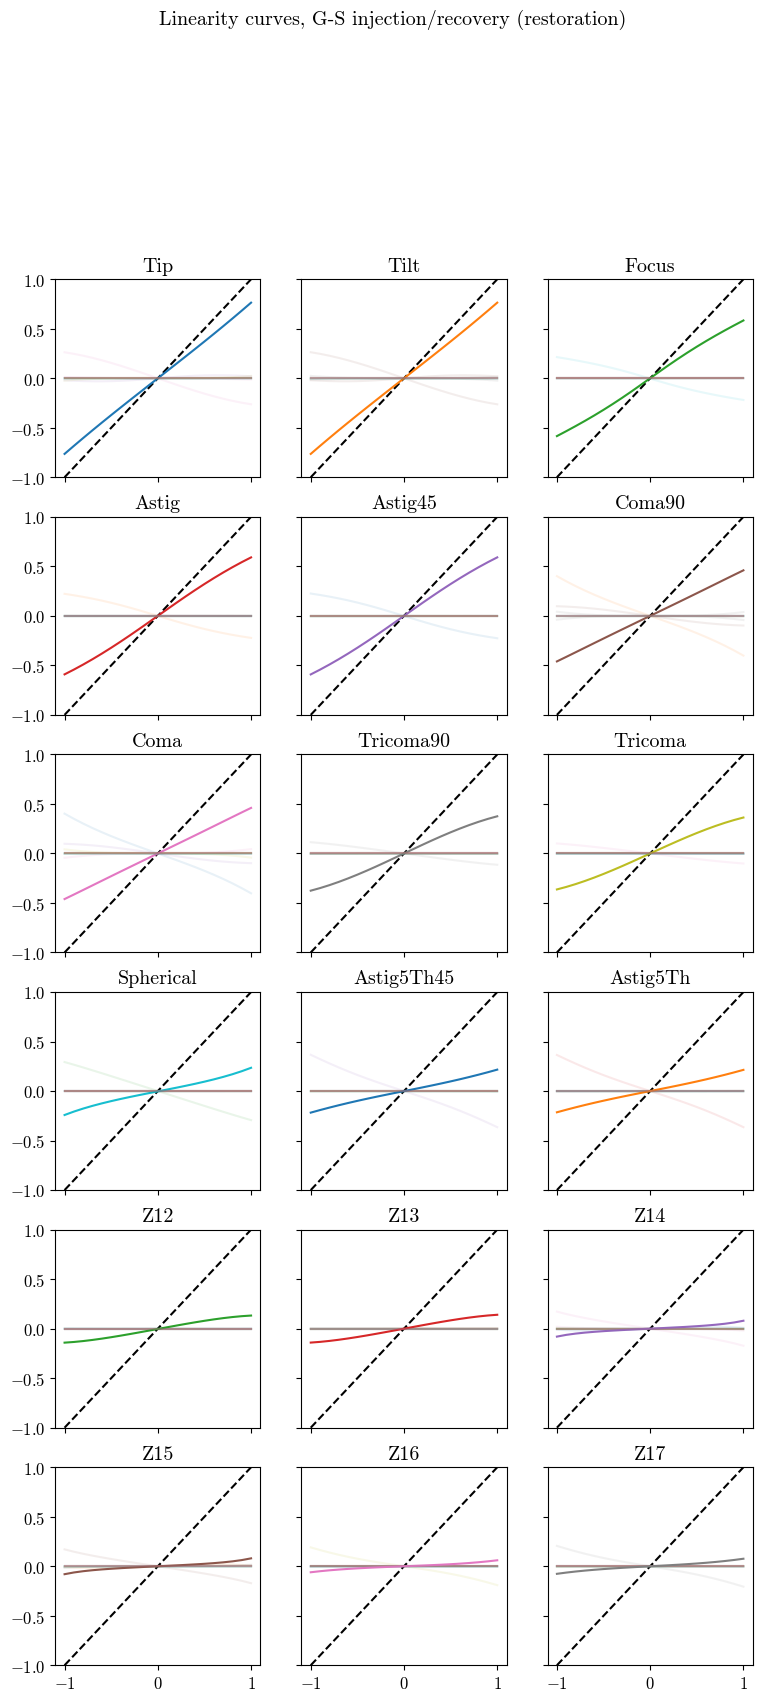

In [13]:
sweep = np.zeros((len(zr), len(ar), len(zr)))
for (i, z) in enumerate(tqdm(zr)):
    for (j, a) in enumerate(ar):
        sweep[i,j,:] = inject_recover_zernikes(z, a, restore_outside=True)
        
plot_linearity(ar, sweep, "G-S injection/recovery (restoration)")

In [15]:
from hcipy import Field

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


Text(0, 0.5, 'GS photons / true photons')

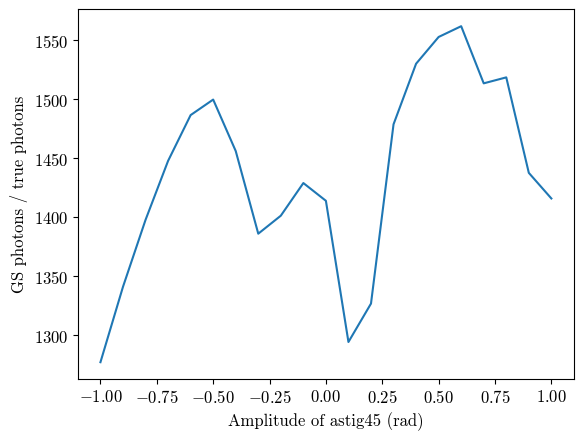

In [16]:
z = 4
amplitudes = np.arange(-1, 1.05, 0.1)
amplitude_scaling = []
for a in tqdm(amplitudes):
    pupil = optics.zernike_to_pupil(z, a)
    focal = optics.focal_propagator(pupil)
    pl_coeffs = lo.lantern_coeffs(focal)
    pl_image = lo.plotting_lantern_output(focal)
    pl_focal = Wavefront(Field(lo.input_to_2d(pl_coeffs @ lo.outputs, zoomed=False).ravel(), focal.grid), wavelength=lo.wl)
    gs_ret = lo.GS(optics, pl_image.ravel(), niter=10)
    focal = optics.focal_propagator(gs_ret)
    gs_pl_image = lo.plotting_lantern_output(focal)
    amplitude_scaling.append(np.sum(np.abs(gs_pl_image) ** 2) / np.sum(np.abs(pl_image) ** 2))
    
plt.plot(amplitudes, amplitude_scaling)
plt.xlabel(f"Amplitude of {zernike_names[z]} (rad)")
plt.ylabel("GS photons / true photons")

In [41]:
zb = optics.zernike_basis

Text(0.5, 1.0, 'True aperture, G-S phase')

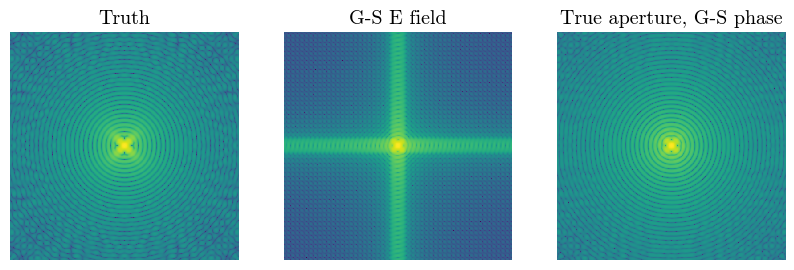

In [109]:
pupil = optics.zernike_to_pupil(3, 0.7)
focal = optics.focal_propagator(pupil)
pl_coeffs = lo.lantern_coeffs(focal)
pl_image = lo.forward(optics, pupil)
pl_focal = Wavefront(Field(lo.input_to_2d(pl_coeffs @ lo.outputs, zoomed=False).ravel(), focal.grid), wavelength=lo.wl)
gs_ret = lo.GS(optics, pl_image.intensity, niter=10)
gs_phase_ret = gs_ret.phase
gs_phase_zerns = zb.coefficients_for(gs_phase_ret)
gs_ret_recon = optics.zernike_to_pupil(np.arange(81), gs_phase_zerns)
gs_focal = optics.focal_propagator(gs_ret)
gs_focal_recon = optics.focal_propagator(gs_ret_recon)
gs_pl_image = lo.plotting_lantern_output(focal)

fig, axs = plt.subplots(1, 3, figsize=(10,5))
for ax in axs:
    ax.axis('off')
imshow_field(np.log10(focal.intensity), ax=axs[0])
axs[0].set_title("Truth")
imshow_field(np.log10(gs_focal.intensity), ax=axs[1])
axs[1].set_title("G-S E field")
imshow_field(np.log10(gs_focal_recon.intensity), ax=axs[2])
axs[2].set_title("True aperture, G-S phase")

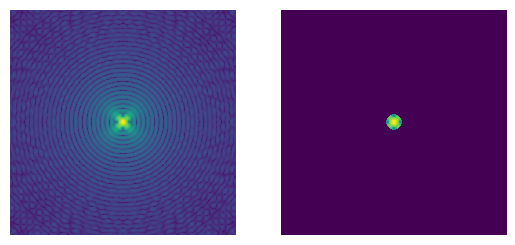

In [149]:
fig, axs = plt.subplots(1, 2)
for ax in axs:
    ax.axis('off')
imshow_field((focal.intensity) ** (1/8), ax=axs[0])
imshow_field((pl_focal.intensity) ** (1/8), ax=axs[1])

This seems to confirm the idea that these systematic offsets we're seeing in the full G-S are an artefact of spatial filtering/something else that's restrictive about the optics: we can get from a flat wavefront to (or pretty close to) the bias-offset versions of the true phases that we get from this injection-recovery test in one or a few Gerchberg-Saxton iterations. This is good because it implies that if we could close the gap induced by this bias, we would converge relatively quickly.

To get a spatially-filtered amplitude in the pupil plane, we look at the intensity of any of the injection-recovery outputs. Note that I'm log-scaling both and limiting their vmin/vmax in log space, so that the effect we want to see isn't drowned out by small variations due to the Airy pattern.

/home/lab/asengupta/photonics/photonics/utils.py:61: RuntimeWarning: divide by zero encountered in log10
  imshow_field(np.log10(f / np.max(f)), **kwargs)


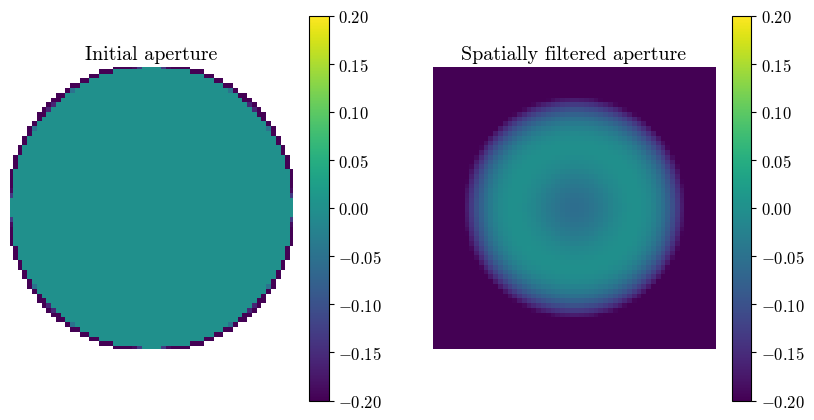

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
for ax in axs:
    ax.axis('off')
imshow_psf(optics.wf.intensity, ax=axs[0], vmax=0.2, vmin=-0.2)
plt.colorbar()
axs[0].set_title("Initial aperture")
rec_wf = inject_recover(optics.wf)
imshow_psf(rec_wf.intensity, ax=axs[1], vmax=0.2, vmin=-0.2)
plt.colorbar()
axs[1].set_title("Spatially filtered aperture");

This looks notably smaller! It's reasonable to expect that replacing the pupil-plane amplitude with this would yield better results. I'll see what impact this has on G-S by using this as my `measuredAmplitude_in`. The cell below has several functions I used in the last notebook but with this change applied.

In [11]:
flat_img = np.abs(lo.plotting_lantern_output(optics.focal_propagator(optics.zernike_to_pupil(0, 0.0)))) ** 2

def pl_residual(focal_field):
    return np.abs(focal_field) ** 2 - flat_img

def tracking_GS(z, a, niter, guess=None, restore_outside=False):
    sim_image = lo.forward(optics, optics.zernike_to_pupil(z, a)).intensity
    plotting_sim_image = np.abs(lo.plotting_lantern_output(lo.focal_propagator.forward(optics.zernike_to_pupil(z, a)))) ** 2
    result = {
        "plotting_sim_image": plotting_sim_image,
        "phase_screens": [],
        "focal_fields": [],
        "recon_zernikes": [],
    }
    for i in range(niter):
        if i == 0:
            EM_in, _, _ = lo.GS_init(optics, sim_image, guess=guess, restore_outside=restore_outside)
        else: # note the difference here
            EM_in = lo.GS_iteration(optics, EM_in, rec_wf, np.sqrt(sim_image), restore_outside=restore_outside)
            
        result["phase_screens"].append(EM_in.phase)
        focal_field = lo.plotting_lantern_output(lo.focal_propagator.forward(EM_in))
        result["focal_fields"].append(focal_field)
        result["recon_zernikes"].append(optics.zernike_basis.coefficients_for(EM_in.phase)[:lo.nmodes])
        
    result["recon_zernikes"] = np.array(result["recon_zernikes"])
    return result

def tracking_GS_movie(z, a, niter=20, crop=100, guess=None, restore_outside=False):
    result = tracking_GS(z, a, niter, guess=guess)
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    im0 = axs[0].imshow(nanify(result["phase_screens"][0].shaped, optics.aperture.shaped), vmin=-np.pi/2, vmax=np.pi/2, cmap="RdBu")
    axs[0].axis('off')
    resid = pl_residual(result["focal_fields"][0])
    lim = np.maximum(np.max(resid), -np.min(resid))
    im1 = axs[1].imshow(resid, vmin=-lim, vmax=lim, cmap="seismic")
    axs[1].axis('off')
    
    def animate(t):
        fig.suptitle(f"Gerchberg-Saxton iterations, {zernike_names[z]}, {a} rad, frame {t}")
        recon_mode = result["recon_zernikes"][t][z]
        axs[0].set_title(f"Phase screen, reconstructed {zernike_names[z]} = {recon_mode:.2f} rad")
        im0.set_data(nanify(result["phase_screens"][t].shaped, optics.aperture.shaped))
        ff = result["focal_fields"][t]
        if t > 0:
            mean_change_since_last = np.mean(100 * np.abs(np.abs(ff) ** 2 / np.abs(result["focal_fields"][t-1]) ** 2 - 1))
        else:
            mean_change_since_last = 0.0
        axs[1].set_title(f"PL residual, change since last = {mean_change_since_last:.2f}%")
        im1.set_data(pl_residual(ff)[crop:-crop,crop:-crop])
    
    anim = animation.FuncAnimation(fig, animate, np.arange(len(result["phase_screens"])))
    plt.close(fig)
    return HTML(anim.to_jshtml(default_mode='loop'))

def tracking_GS_zernikes(z, a, niter=20, guess=None, restore_outside=False):
    result = tracking_GS(z, a, niter, guess=guess, restore_outside=restore_outside)
    zdecomps = result["recon_zernikes"].T
    plt.hlines(a, 0, zdecomps.shape[1] - 1, label="Target")
    for (i, r) in enumerate(zdecomps):
        if i == z:
            plt.plot(r, label="Injected mode", color="k")
        else:
            plt.plot(r, alpha=0.1, color="r")
    plt.xticks(np.arange(0, zdecomps.shape[1], 4))
    plt.xlabel("Gerchberg-Saxton iteration")
    plt.ylabel("Amplitude (rad)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.subplots_adjust(right=0.8)
    plt.suptitle(f"Gerchberg-Saxton iterations, {zernike_names[z]}, {a} rad")


Unfortunately it looks like this doesn't do much - we get a result that's the same as/slightly worse than before:

In [20]:
tracking_GS_movie(4, -0.5, 21)

This is identical even when I'm using both the filtered aperture and restoring the focal-plane electric field outside the PL footprint:

In [19]:
tracking_GS_movie(4, -0.5, 21, restore_outside=True)

And by eye, the linearity curves seem more or less identical to what we saw with the previous, un-filtered, amplitude.

  0%|          | 0/18 [00:00<?, ?it/s]100%|██████████| 18/18 [06:48<00:00, 22.69s/it]


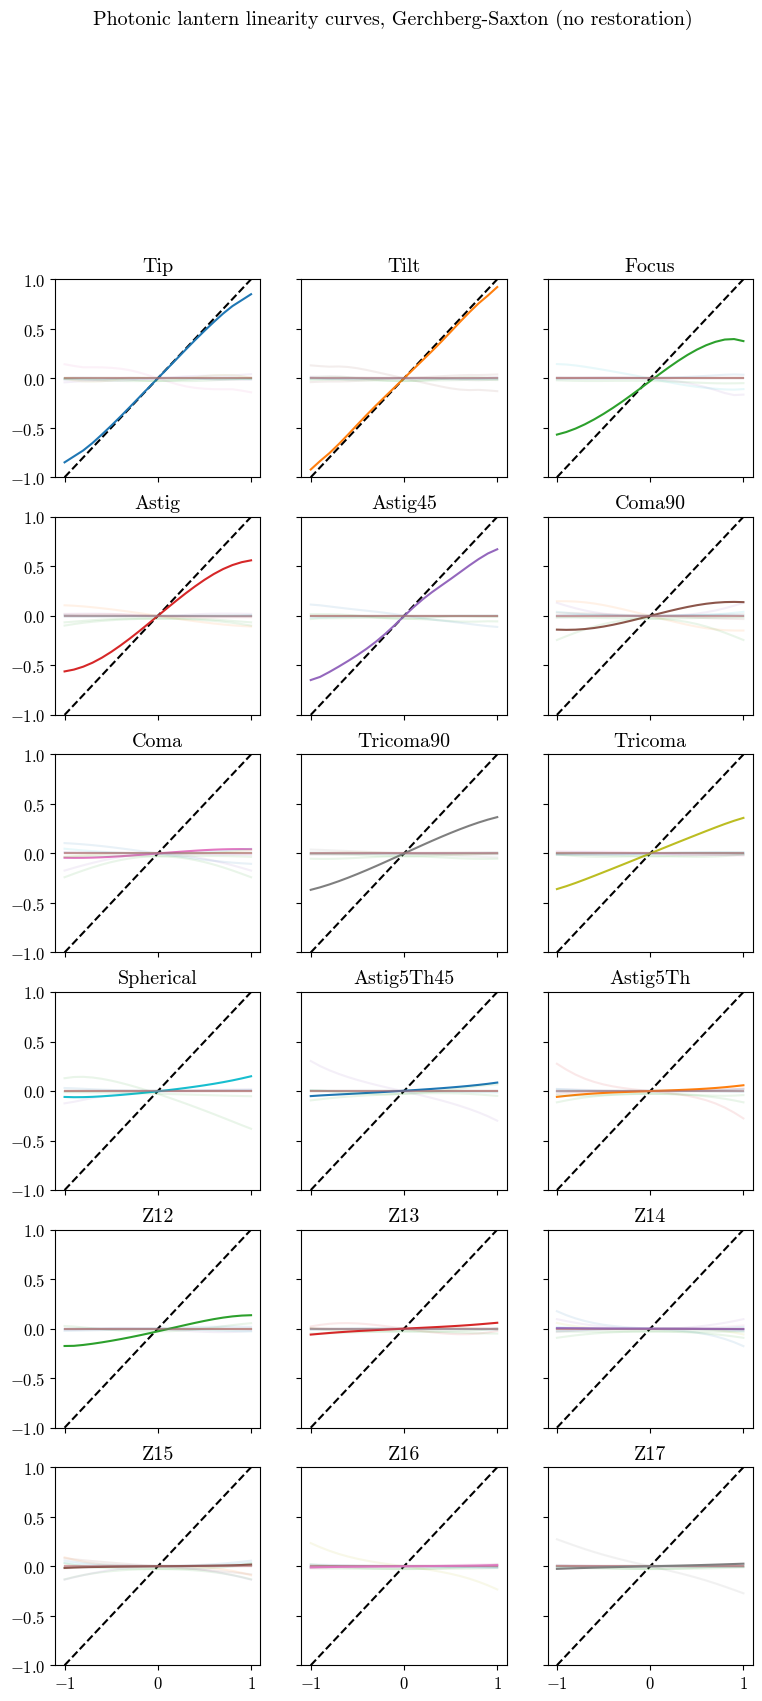

In [13]:
zr = np.arange(18)
ar = np.arange(-1.0, 1.01, 0.1)
sweep = np.zeros((len(zr), len(ar), len(zr)))
for (i, z) in enumerate(tqdm(zr)):
    for (j, a) in enumerate(ar):
        result = tracking_GS(z, a, 10)
        sweep[i,j,:] = result["recon_zernikes"][-1]
        
plot_linearity(ar, sweep, "Gerchberg-Saxton (no restoration)")

Overall it seems like these changes don't have any impact on the performance of G-S.